In [243]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [244]:
# Load in Dataframes
sdf = spark.read.parquet('../data/curated/properties_population.parquet')
growth = spark.read.parquet('../data/curated/growth_rate_20years.parquet')
distances = spark.read.parquet('../data/curated/distances.parquet')
distances = distances.toPandas()

In [245]:
sdf = sdf.withColumn(
    # Properties priced per week
    'House',
    F.when(F.lower(F.col('property_type')).contains('house'), True).otherwise(False)
).withColumn(
    # see if property is priced per annum
    'flat',
    F.when(F.lower(F.col('property_type')).contains('flat') \
        | F.lower(F.col('property_type')).contains('apartment'), True ).otherwise(False)
)

In [246]:
# Dropping all duplicate rows
sdf1 = sdf.dropDuplicates()

sdf1 = sdf1[sdf1['property_type'] != 'Carspace']

sdf1

postcode,cost,suburb,furnished,property_type,beds,baths,parking,region,lgaregion,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median rent,median family weekly income,median age,total region male population - 2022,total region female population - 2022,House,flat
3141,1250.0,south-yarra,0,House,4.0,1.0,0,Major Cities of A...,Melbourne,11881,13149,25028,18039,415,3106,33,2538968.0,2598457.0,true,false
3183,410.0,st-kilda-east,0,Apartment / Unit ...,1.0,1.0,1,Major Cities of A...,Glen Eira,8854,9103,17964,14438,396,2877,34,2538968.0,2598457.0,false,true
3336,545.0,fraser-rise,0,House,4.0,2.0,2,Major Cities of A...,Melton,8760,8975,17737,14026,421,2328,31,2538968.0,2598457.0,true,false
3147,775.0,ashwood,0,Townhouse,3.0,2.0,1,Major Cities of A...,Stonnington,7439,7664,15102,12806,410,2969,40,2538968.0,2598457.0,true,false
3025,875.0,altona-north,0,House,4.0,3.0,2,Major Cities of A...,Hobsons Bay,6254,6713,12962,10934,400,2137,37,2538968.0,2598457.0,true,false
3939,590.0,rosebud,0,House,3.0,1.0,4,Inner Regional Au...,Mornington Peninsula,7570,8330,15900,14053,350,1624,50,606425.0,621339.0,true,false
3356,450.0,delacombe,0,House,4.0,2.0,2,Inner Regional Au...,Ballarat,7298,8303,15601,13952,270,1428,39,606425.0,621339.0,true,false
3004,625.0,melbourne,0,Apartment / Unit ...,1.0,1.0,0,Major Cities of A...,Melbourne,5655,5827,11482,7103,451,2727,37,2538968.0,2598457.0,false,true
3336,570.0,fraser-rise,0,House,4.0,2.0,0,Major Cities of A...,Melton,8760,8975,17737,14026,421,2328,31,2538968.0,2598457.0,true,false
3338,650.0,brookfield,0,House,4.0,2.0,2,Inner Regional Au...,Wyndham,18295,18769,37062,28432,341,1805,31,606425.0,621339.0,true,false


In [247]:
from pyspark.sql import functions as F

growth = growth.filter((F.col('postcode')>0))

# Removing NULL values and getting data from'All Properties'
columns_to_fill = ['1 bed flats', '2 bed flats', '3 bed flats', '2 bed houses', '3 bed houses', '4 bed houses']

for col in columns_to_fill:
    growth = growth.withColumn(col, F.coalesce(growth[col], growth['All Properties']))

In [248]:
from pyspark.sql import functions as F

# Change from columns to merge 
growth_unpivoted = growth.select(
    "postcode",
    F.expr("stack(6, '1 bed flats', `1 bed flats`, '2 bed flats', `2 bed flats`, '3 bed flats', \
           `3 bed flats`, '2 bed houses', `2 bed houses`, '3 bed houses', `3 bed houses`, '4 bed houses', \
           `4 bed houses`) as (bed_column, growth_value)")
)

# Create the bed_column in sdf1
sdf1 = sdf1.withColumn(
    "bed_column",
    F.when((F.col("property_type").contains("flat")) & (F.col("beds") == 1), "1 bed flats")
    .when((F.col("property_type").contains("flat")) & (F.col("beds") == 2), "2 bed flats")
    .when((F.col("property_type").contains("flat")) & (F.col("beds") == 3), "3 bed flats")
    .when((F.col("property_type").contains("house")) & (F.col("beds") == 2), "2 bed houses")
    .when((F.col("property_type").contains("house")) & (F.col("beds") == 3), "3 bed houses")
    .when((F.col("property_type").contains("house")) & (F.col("beds") == 4), "4 bed houses")
)

# Perform the join after ensuring both DataFrames have 'postcode' and 'bed_column'
sdf_growth = sdf1.join(growth_unpivoted, on=['postcode', 'bed_column'], how='inner')

# Show the result
sdf_growth = sdf_growth.drop('flat')
sdf_growth = sdf_growth.drop('House')

sdf_growth.show()

+--------+------------+------+--------------+---------+-------------+----+-----+-------+--------------------+--------------------+----------------------------+------------------------------+-----------------------+-------------------+-----------+---------------------------+----------+-----------------------------------+-------------------------------------+------------------+
|postcode|  bed_column|  cost|        suburb|furnished|property_type|beds|baths|parking|              region|           lgaregion|total male population - 2021|total female population - 2021|total population - 2021|australian citizens|median rent|median family weekly income|median age|total region male population - 2022|total region female population - 2022|      growth_value|
+--------+------------+------+--------------+---------+-------------+----+-----+-------+--------------------+--------------------+----------------------------+------------------------------+-----------------------+-------------------+--------

Merging with quarterly rent analysis


In [249]:
pdf_reg = sdf_growth.toPandas()


In [250]:
pdf_reg['postcode'] = pdf_reg['postcode'].astype(str)

In [251]:
pdf_reg = pdf_reg.drop(['region', 'lgaregion', 'suburb', 'bed_column', 'property_type'], axis = 1)

In [252]:
distances = distances.drop(['name', 'latitude', 'longitude'], axis = 1)

In [253]:
distances = distances.groupby('postcode').mean()
distances = distances.dropna()

In [254]:
growth_pdf = growth.toPandas()

import pandas as pd
df_merged = pd.merge(pdf_reg, distances, on='postcode', how='inner')
df_merged = df_merged.drop_duplicates()
print(df_merged)
df_merged.to_parquet('../data/curated/regression_data.parquet', engine='pyarrow', index=False)

    postcode    cost  furnished  beds  baths  parking  \
0       3187  1300.0          0   4.0    3.0        3   
1       3207  1600.0          0   3.0    2.0        1   
2       3204  1090.0          0   4.0    3.0        2   
3       3044   450.0          0   2.0    1.0        1   
4       3040   600.0          0   2.0    2.0        1   
..       ...     ...        ...   ...    ...      ...   
716     3040   670.0          0   3.0    3.0        2   
717     3046   525.0          0   2.0    2.0        1   
718     3204   620.0          0   2.0    1.0        1   
719     3043   650.0          0   3.0    2.0        2   
720     3630   350.0          0   2.0    1.0        1   

     total male population - 2021  total female population - 2021  \
0                            8014                            8744   
1                            8439                            9196   
2                           16140                           16991   
3                           13847      

In [255]:
# # Boosting
# from sklearn.ensemble import GradientBoostingRegressor
# >>> model = GradientBoostingRegressor(random_state=0).fit(x_train, y_train)
# >>> model.score(x_train, y_train)
# 0.8083859166342285
# >>> model.score(x_test, y_test)
# 0.7802104901623703

# >>> from sklearn.ensemble import RandomForestRegressor
# >>> model = RandomForestRegressor(random_state=0).fit(x_train, y_train)
# >>> model.score(x_train, y_train)
# 0.9727449572570027
# >>> model.score(x_test, y_test)

Exploratory Data Analysis

In [256]:
df_merged = df_merged.dropna()
df_merged

,postcode,cost,furnished,beds,baths,parking,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median rent,median family weekly income,median age,total region male population - 2022,total region female population - 2022,growth_value,distance_to_closest_school_km,distance_to_cbd
0,3187,1300.0,0,4.0,3.0,3,8014,8744,16757,14596,600,3400,45,2538968.0,2598457.0,1.307692,0.667444,14.428361
1,3207,1600.0,0,3.0,2.0,1,8439,9196,17633,14528,540,3264,42,2538968.0,2598457.0,1.209302,1.544370,5.327425
2,3204,1090.0,0,4.0,3.0,2,16140,16991,33130,27132,461,2860,39,2538968.0,2598457.0,2.030303,0.815452,16.923560
3,3044,450.0,0,2.0,1.0,1,13847,14847,28701,24665,401,2568,37,2538968.0,2598457.0,1.619048,0.775736,11.312321
4,3040,600.0,0,2.0,2.0,1,12997,13727,26722,23487,385,2974,39,2538968.0,2598457.0,1.227273,1.096919,11.138174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,3040,670.0,0,3.0,3.0,2,12997,13727,26722,23487,385,2974,39,2538968.0,2598457.0,1.521739,1.096919,11.138174
717,3046,525.0,0,2.0,2.0,1,18287,18483,36772,27661,371,2053,35,2538968.0,2598457.0,1.500000,0.723039,13.928184
718,3204,620.0,0,2.0,1.0,1,16140,16991,33130,27132,461,2860,39,2538968.0,2598457.0,1.375000,0.815452,16.923560
719,3043,650.0,0,3.0,2.0,2,8872,9047,17912,15436,375,1881,41,2538968.0,2598457.0,1.400000,1.512000,18.030444


<Axes: >

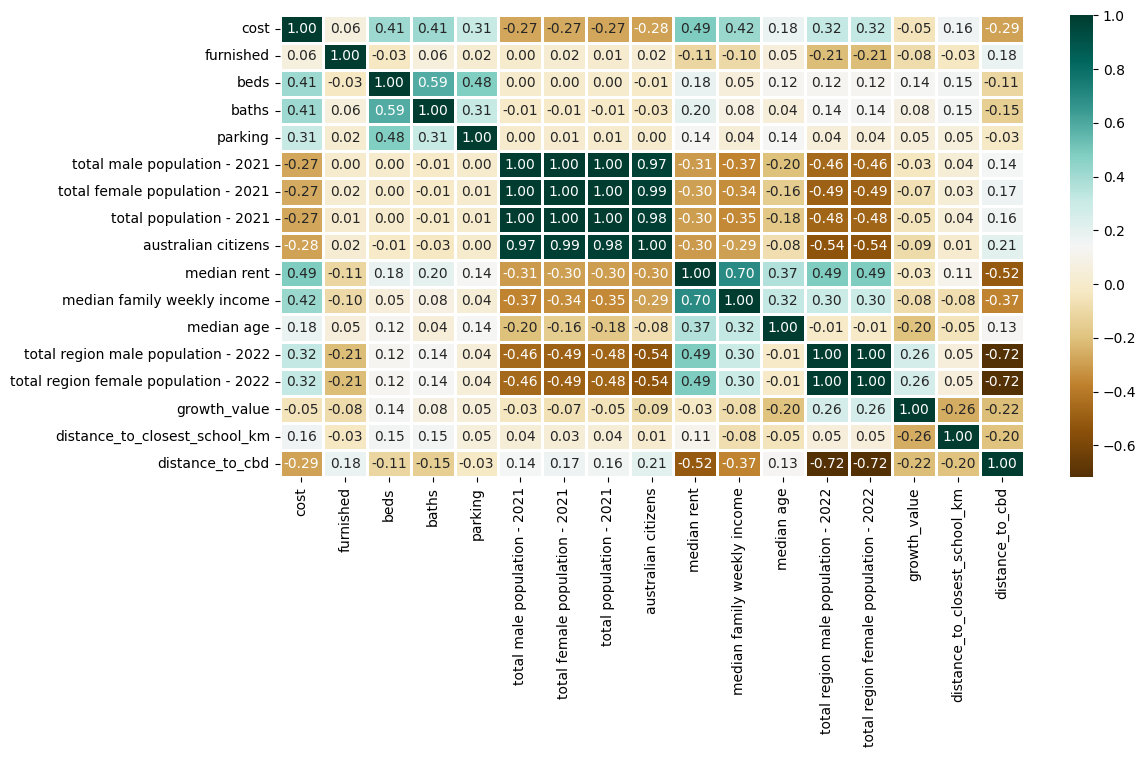

In [257]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_pdf = df_merged.drop('postcode',axis=1)
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_pdf.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

In [258]:
# # stratified sampling --

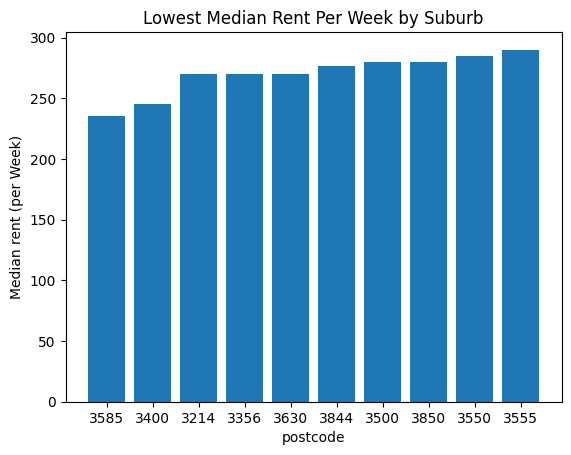

In [259]:
medians = df_merged.groupby(["postcode"])["median rent"].median() 

import pandas as pd
median_pdf = pd.DataFrame(medians)
median_pdf = median_pdf.sort_values(by=['median rent'])

# Importing required libraries 
import matplotlib.pyplot as plt 

# creating the bar plot
plt.bar(list(median_pdf[0:10].index), median_pdf['median rent'][0:10]) # fix x label, fix outliers, data check

plt.xlabel("postcode")
plt.ylabel("Median rent (per Week)")
plt.title("Lowest Median Rent Per Week by Suburb")
plt.show()

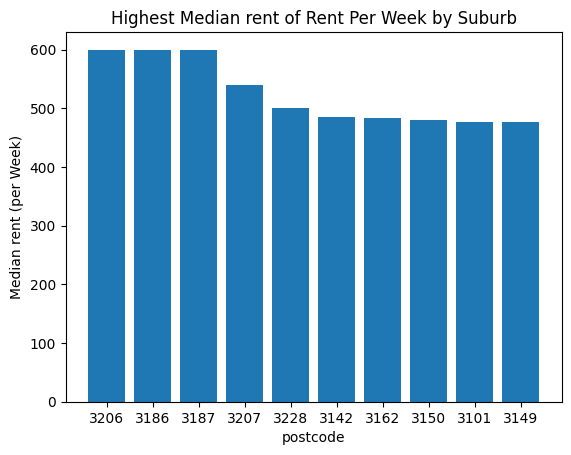

In [260]:
medians = df_merged.groupby(["postcode"])["median rent"].median() 

import pandas as pd
median_pdf = pd.DataFrame(medians)
median_pdf = median_pdf.sort_values(by=['median rent'], ascending = False)

# Importing required libraries 
import matplotlib.pyplot as plt 

#fig = plt.figure(figsize = (7, 4))

# creating the bar plot
plt.bar(list(median_pdf[0:10].index), median_pdf['median rent'][0:10]) # fix x label

plt.xlabel("postcode")
plt.ylabel("Median rent (per Week)")
plt.title("Highest Median rent of Rent Per Week by Suburb")
plt.show()

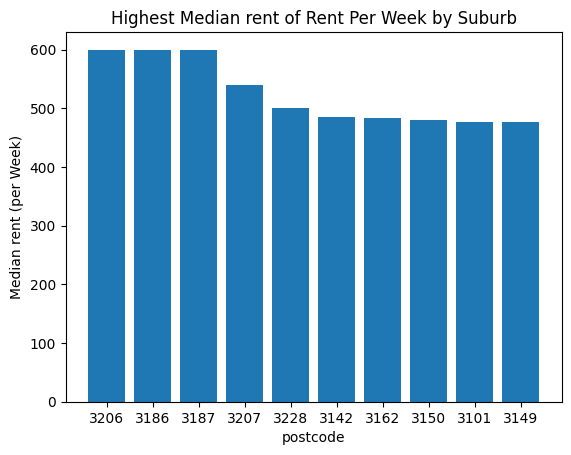

In [261]:
means = df_merged.groupby(["postcode"])["median rent"].mean() 

import pandas as pd
means_pdf = pd.DataFrame(means)
means_pdf = means_pdf.sort_values(by=['median rent'], ascending = False)

# Importing required libraries 
import matplotlib.pyplot as plt 

# creating the bar plot
plt.bar(list(means_pdf[0:10].index), means_pdf['median rent'][0:10]) # fix x label, fix outliers, data check

plt.xlabel("postcode")
plt.ylabel("Median rent (per Week)")
plt.title("Highest Median rent of Rent Per Week by Suburb")
plt.show()

# Scatterplots - sample

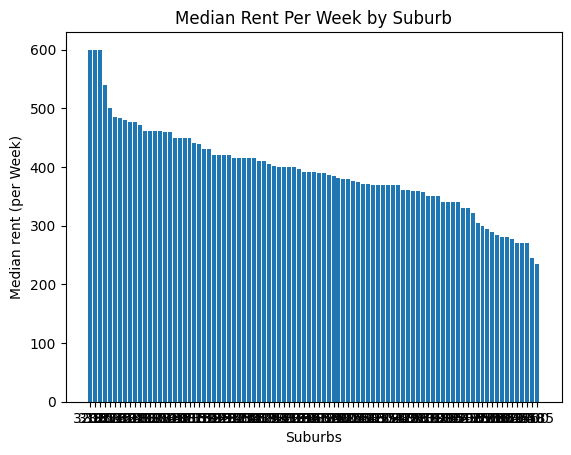

In [262]:
# Importing required libraries 
import matplotlib.pyplot as plt 

# creating the bar plot
plt.bar(list(means_pdf.index), means_pdf['median rent']) # can input top 10 indices

plt.xlabel("Suburbs")
plt.ylabel("Median rent (per Week)")
plt.title("Median Rent Per Week by Suburb")
plt.show()

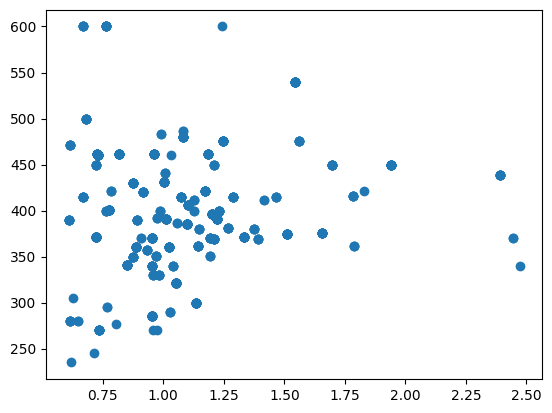

In [263]:
import matplotlib.pyplot as plt

plt.scatter(df_merged['distance_to_closest_school_km'], df_merged['median rent'])
plt.show()

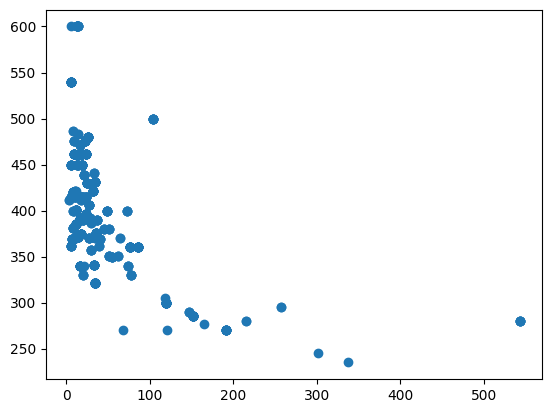

In [264]:
plt.scatter(df_merged['distance_to_cbd'], df_merged['median rent'])
plt.show()

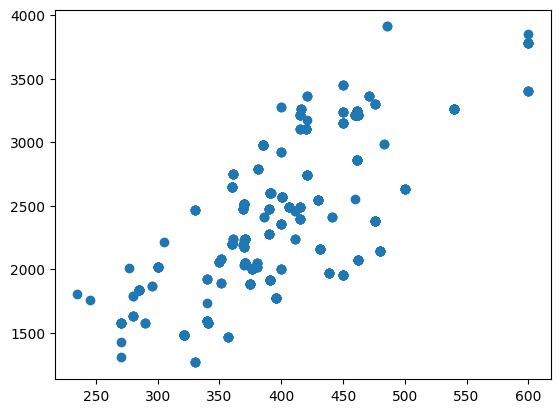

In [265]:
import matplotlib.pyplot as plt

plt.scatter(df_merged['median rent'], df_merged['median family weekly income'])
plt.show()

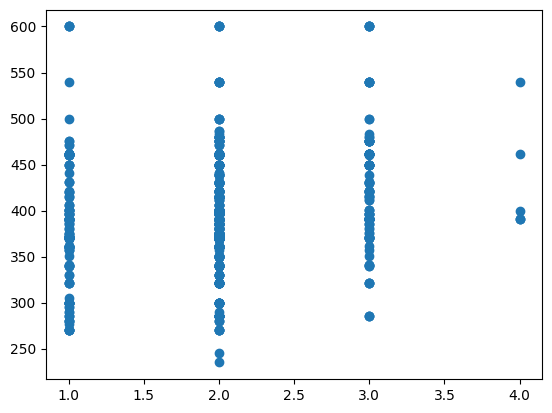

In [266]:
import matplotlib.pyplot as plt

plt.scatter(df_merged['baths'], df_merged['median rent'])
plt.show()

In [267]:
df_merged = df_merged.round()
df_merged = df_merged.dropna()
df_merged = df_merged.drop_duplicates()

In [268]:
suburbs = df_merged.groupby(['postcode']).median()
suburbs = suburbs.astype(int)
suburbs

# list(suburbs['median rent'].values)

,cost,furnished,beds,baths,parking,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median rent,median family weekly income,median age,total region male population - 2022,total region female population - 2022,growth_value,distance_to_closest_school_km,distance_to_cbd
postcode,,,,,,,,,,,,,,,,,
3008,1025,0,3,2,2,8037,7458,15495,6983,411,2461,32,2538968,2598457,1,1,3
3011,700,0,3,2,1,11361,10913,22278,16807,369,2474,34,2538968,2598457,2,1,7
3012,635,0,3,2,1,13593,13423,27023,21594,370,2513,35,2538968,2598457,2,1,10
3013,695,0,3,2,1,7603,8038,15636,13764,462,3216,37,2538968,2598457,2,1,9
3015,650,0,3,2,2,9144,9492,18634,16402,460,3214,38,2538968,2598457,2,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,575,0,3,2,2,27135,28453,55588,46026,351,1894,33,606425,621339,2,1,61
3844,430,0,2,1,1,15074,16106,31179,27704,277,2007,40,128873,128617,1,1,165
3850,390,0,2,1,1,7408,8063,15472,13824,280,1787,42,606425,621339,2,1,216


In [269]:
# Round up to the nearest 10
import numpy as np
rounded_median_rent= [(np.ceil(x/10) * 10) for x in list(df_merged['median rent'].values)]
rounded_median_rent = [int(x) for x in rounded_median_rent]
df_merged['rounded_median_rent'] = rounded_median_rent
df_merged

,postcode,cost,furnished,beds,baths,parking,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median rent,median family weekly income,median age,total region male population - 2022,total region female population - 2022,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent
0,3187,1300.0,0,4.0,3.0,3,8014,8744,16757,14596,600,3400,45,2538968.0,2598457.0,1.0,1.0,14.0,600
1,3207,1600.0,0,3.0,2.0,1,8439,9196,17633,14528,540,3264,42,2538968.0,2598457.0,1.0,2.0,5.0,540
2,3204,1090.0,0,4.0,3.0,2,16140,16991,33130,27132,461,2860,39,2538968.0,2598457.0,2.0,1.0,17.0,470
3,3044,450.0,0,2.0,1.0,1,13847,14847,28701,24665,401,2568,37,2538968.0,2598457.0,2.0,1.0,11.0,410
4,3040,600.0,0,2.0,2.0,1,12997,13727,26722,23487,385,2974,39,2538968.0,2598457.0,1.0,1.0,11.0,390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,3040,670.0,0,3.0,3.0,2,12997,13727,26722,23487,385,2974,39,2538968.0,2598457.0,2.0,1.0,11.0,390
717,3046,525.0,0,2.0,2.0,1,18287,18483,36772,27661,371,2053,35,2538968.0,2598457.0,2.0,1.0,14.0,380
718,3204,620.0,0,2.0,1.0,1,16140,16991,33130,27132,461,2860,39,2538968.0,2598457.0,1.0,1.0,17.0,470
719,3043,650.0,0,3.0,2.0,2,8872,9047,17912,15436,375,1881,41,2538968.0,2598457.0,1.0,2.0,18.0,380


Regression


In [270]:
unique_vals = ((df_merged['rounded_median_rent'].value_counts()))
unique_vals

for i in unique_vals[unique_vals == 1].index:
    target = df_merged[df_merged['rounded_median_rent'] == i] # Need more than 1 sample for each unique value for modelling
    df_merged = df_merged.drop(target.index[0])

df_merged
   

,postcode,cost,furnished,beds,baths,parking,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median rent,median family weekly income,median age,total region male population - 2022,total region female population - 2022,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent
0,3187,1300.0,0,4.0,3.0,3,8014,8744,16757,14596,600,3400,45,2538968.0,2598457.0,1.0,1.0,14.0,600
1,3207,1600.0,0,3.0,2.0,1,8439,9196,17633,14528,540,3264,42,2538968.0,2598457.0,1.0,2.0,5.0,540
2,3204,1090.0,0,4.0,3.0,2,16140,16991,33130,27132,461,2860,39,2538968.0,2598457.0,2.0,1.0,17.0,470
3,3044,450.0,0,2.0,1.0,1,13847,14847,28701,24665,401,2568,37,2538968.0,2598457.0,2.0,1.0,11.0,410
4,3040,600.0,0,2.0,2.0,1,12997,13727,26722,23487,385,2974,39,2538968.0,2598457.0,1.0,1.0,11.0,390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,3040,670.0,0,3.0,3.0,2,12997,13727,26722,23487,385,2974,39,2538968.0,2598457.0,2.0,1.0,11.0,390
717,3046,525.0,0,2.0,2.0,1,18287,18483,36772,27661,371,2053,35,2538968.0,2598457.0,2.0,1.0,14.0,380
718,3204,620.0,0,2.0,1.0,1,16140,16991,33130,27132,461,2860,39,2538968.0,2598457.0,1.0,1.0,17.0,470
719,3043,650.0,0,3.0,2.0,2,8872,9047,17912,15436,375,1881,41,2538968.0,2598457.0,1.0,2.0,18.0,380


In [271]:
sdf_merged = spark.createDataFrame(df_merged)
sdf_merged = sdf_merged.drop('median rent')
sdf_merged

postcode,cost,furnished,beds,baths,parking,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median family weekly income,median age,total region male population - 2022,total region female population - 2022,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent
3187,1300.0,0,4.0,3.0,3,8014,8744,16757,14596,3400,45,2538968.0,2598457.0,1.0,1.0,14.0,600
3207,1600.0,0,3.0,2.0,1,8439,9196,17633,14528,3264,42,2538968.0,2598457.0,1.0,2.0,5.0,540
3204,1090.0,0,4.0,3.0,2,16140,16991,33130,27132,2860,39,2538968.0,2598457.0,2.0,1.0,17.0,470
3044,450.0,0,2.0,1.0,1,13847,14847,28701,24665,2568,37,2538968.0,2598457.0,2.0,1.0,11.0,410
3040,600.0,0,2.0,2.0,1,12997,13727,26722,23487,2974,39,2538968.0,2598457.0,1.0,1.0,11.0,390
3182,1050.0,0,3.0,2.0,1,11278,11156,22438,16227,2791,37,2538968.0,2598457.0,1.0,1.0,8.0,390
3141,1000.0,0,3.0,2.0,1,11881,13149,25028,18039,3106,33,2538968.0,2598457.0,1.0,1.0,6.0,420
3931,860.0,0,3.0,2.0,2,11959,13798,25759,23033,2001,50,2538968.0,2598457.0,2.0,1.0,73.0,400
3218,600.0,0,3.0,2.0,2,7219,7724,14942,13259,2464,37,606425.0,621339.0,2.0,1.0,77.0,330
3204,1125.0,0,4.0,3.0,2,16140,16991,33130,27132,2860,39,2538968.0,2598457.0,2.0,1.0,17.0,470


In [272]:
from sklearn.model_selection import train_test_split

# Label
y = df_merged['rounded_median_rent'] 

# Predictors
x = df_merged.drop(['rounded_median_rent'], axis=1)

# Create train, test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=10, stratify=y)

# Scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [273]:
# Linear Regression

from sklearn import datasets, linear_model, metrics
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test , y_test)

0.9970213182815038

In [274]:
# regression coefficients
print('Coefficients: ', reg.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))

y_pred = reg.predict(X_test)

Coefficients:  [-6.19992957e-01 -7.43246874e-02  1.25850055e-01 -1.82235276e-02
  1.87873785e-01 -9.12375574e-02  2.51137866e+03  2.58473250e+03
 -5.08241315e+03 -8.93156297e+00  5.99354972e+01 -2.64452742e-01
  6.43209640e-01  1.09486039e+03 -1.09511152e+03  8.04523524e-01
 -6.12304000e-01 -1.82084766e+00]
Variance score: 0.9970213182815038


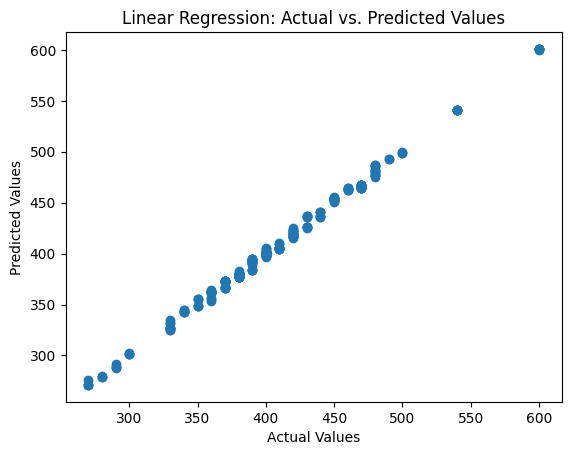

In [275]:
plt.scatter(y_test, y_pred) # Add y=x
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs. Predicted Values")
plt.show() # Much better performance  

In [276]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [277]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [278]:
rf_feature_importances = reg.feature_importances_
rf_feature_importances = pd.Series(
    rf_feature_importances, index=X_train.columns.values
    ).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x=rf_feature_importances, y=rf_feature_importances.index)
plt.xlabel('Feature Importance');
plt.ylabel('Feature');

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [279]:
import numpy as np
from glmnet import ElasticNet


# LASSO Model
elastic_net_model = ElasticNet(alpha=1) 
elastic_net_model.fit(x,y)

ElasticNet()

In [280]:
# Lambda Value
print(f'Best lambda value for LASSO: {elastic_net_model.lambda_best_[0]}')

Best lambda value for LASSO: 0.8469306288360244


In [281]:
y_pred = elastic_net_model.predict(X_test)

# Import necessary libraries
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# Print the model coefficients
print("Elastic Net Coefficients:")
print(elastic_net_model.coef_)
# Print the model intercept
print("Elastic Net Intercept:")
print(elastic_net_model.intercept_)
r2_score(y_test,y_pred)

Mean Squared Error: 159033.6240985864
Elastic Net Coefficients:
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.97744907  0.
  0.          0.          0.          0.          0.         -0.01132016]
Elastic Net Intercept:
13.62294272025656


-41.157655372631794

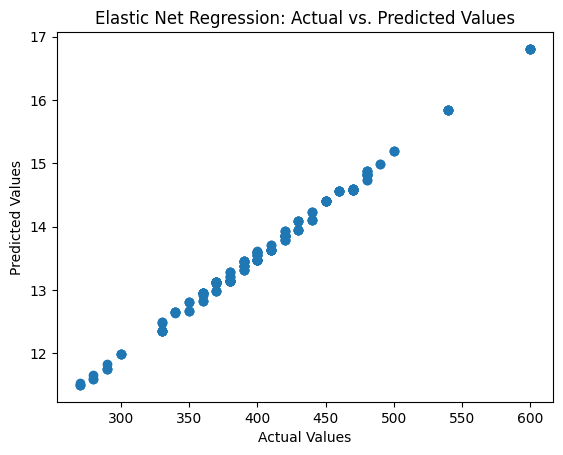

In [282]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Elastic Net Regression: Actual vs. Predicted Values")
plt.show()

In [39]:
# Begin forecasting the rental properties for the next 3-years by suburb or any other suitable
# granularity (we will let groups decide on the granularity). Whilst working on this, groups are
# expected to also present some analysis on what features are useful in making a certain suburb
# more expensive and sought after.

In [40]:
# Groups are to continue working on their predictions and analysis. Additionally, prepare a
# summary notebook (3-5 minutes max) and walk your Tutor through the current findings and
# any additional insights so far. This task should assist in helping groups formulate their answers
# to the 3 big questions.

In [41]:
# Summarise and output the 3-year predictions for your chosen granularity (i.e suburb or cluster
# of properties) and provide some form of an answer for the 3 big questions.